In [ ]:
# library import
import pandas as pd
import numpy as np

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
import zipfile
outer_zip_path = '/content/nyc-taxi-trip-duration.zip'
extraction_dir = '/content/nyc-taxi-trip-duration'
import os
os.makedirs(extraction_dir, exist_ok=True)
with zipfile.ZipFile(outer_zip_path, 'r') as zip_ref:
  zip_ref.extractall(extraction_dir)

import glob
inner_zip_files = glob.glob(f'{extraction_dir}/**/*.zip', recursive=True)

for inner_zip_path in inner_zip_files:
    # Define an extraction directory for each inner zip file (optional, or extract to a common location)
    inner_extraction_dir = os.path.join(os.path.dirname(inner_zip_path), os.path.basename(inner_zip_path).replace('.zip', ''))
    os.makedirs(inner_extraction_dir, exist_ok=True)

    with zipfile.ZipFile(inner_zip_path, 'r') as zip_ref:
        zip_ref.extractall(inner_extraction_dir)
    print(f"Extracted: {inner_zip_path} to {inner_extraction_dir}")

Extracted: /content/nyc-taxi-trip-duration/test.zip to /content/nyc-taxi-trip-duration/test
Extracted: /content/nyc-taxi-trip-duration/train.zip to /content/nyc-taxi-trip-duration/train
Extracted: /content/nyc-taxi-trip-duration/sample_submission.zip to /content/nyc-taxi-trip-duration/sample_submission


In [ ]:
def clean(data):
    '''
    Simple pre-processing/cleaning
    '''
    # Since there are less than 10k rows with anomalies in trip_duration (in common sense), we can safely remove them
    duration_mask = ((data.trip_duration < 60) | # < 1 min
             (data.trip_duration > 3600 * 2)) # > 2 hours
    print('Anomalies in trip duration, %: {:.2f}'.format(data[duration_mask].shape[0] / data.shape[0] * 100))

    data = data[~duration_mask]
    data.trip_duration = data.trip_duration.astype(np.uint16)
    print('Trip duration in seconds: {} to {}'.format(data.trip_duration.min(), data.trip_duration.max()))

    # Drop trips with passenger count = 0, since there are only 17 of them
    print('Empty trips: {}'.format(data[data.passenger_count == 0].shape[0]))
    data = data[data.passenger_count > 0]

    # Convert this feature into categorical type
    data.store_and_fwd_flag = data.store_and_fwd_flag.astype('category')

    # month (pickup and dropoff)
    data['mm_pickup'] = data.pickup_datetime.dt.month.astype(np.uint8)
    data['mm_dropoff'] = data.dropoff_datetime.dt.month.astype(np.uint8)

    # day of week
    data['dow_pickup'] = data.pickup_datetime.dt.weekday.astype(np.uint8)
    data['dow_dropoff'] = data.dropoff_datetime.dt.weekday.astype(np.uint8)

    # day hour
    data['hh_pickup'] = data.pickup_datetime.dt.hour.astype(np.uint8)
    data['hh_dropoff'] = data.dropoff_datetime.dt.hour.astype(np.uint8)

    return data

In [ ]:
import os

# Create the 'Figures' directory if it doesn't exist
if not os.path.exists('Figures'):
    os.makedirs('Figures')

In [ ]:
def PickupPlot1(data):
    '''
    Pickup time distribution by hour-of-day
    '''
    plt.figure(figsize=(12,2))

    data = data.groupby('hh_pickup').aggregate({'id':'count'}).reset_index()
    sns.barplot(x='hh_pickup', y='id', data=data)

    plt.title('Pick-ups Hour Distribution')
    plt.xlabel('Hour of Day, 0-23')
    plt.ylabel('No of Trips made')

    plt.savefig('Figures/pickups-hour-distribution.png')

In [ ]:
def PickupPlot2(data, dow_names):
    '''
    Pickup time distribution by day-of-week
    '''
    plt.figure(figsize=(12,2))

    data = data.groupby('dow_pickup').aggregate({'id':'count'}).reset_index()
    sns.barplot(x='dow_pickup', y='id', data=data)

    plt.title('Pick-ups Weekday Distribution')
    plt.xlabel('Trip Duration, minutes')
    plt.xticks(range(0,7), dow_names, rotation='horizontal')
    plt.ylabel('No of Trips made')

    plt.savefig('Figures/pickups-weekday-distribution.png')


In [ ]:
def PickupPlot3(data, dow_names):
    '''
    Pickup heatmap of day-of-week vs. hour-of-day
    '''
    plt.figure(figsize=(12,2))
    sns.heatmap(data=pd.crosstab(data.dow_pickup, data.hh_pickup, values=data.vendor_id, aggfunc='count', normalize='index'))

    plt.title('Pickup heatmap, Day-of-Week vs. Day Hour')
    plt.ylabel('Weekday')
    plt.xlabel('Day Hour, 0-23')
    plt.yticks(range(0,7), dow_names[::-1], rotation='horizontal')

    plt.savefig('Figures/pickup-heatmap-day-of-week-vs-hour.png')


In [ ]:
def TripDurationPlot1(data):
    '''
    Trip duration distribution in minutes
    '''
    plt.figure(figsize=(12,3))

    plt.title('Trip Duration Distribution')
    plt.xlabel('Trip Duration, minutes')
    plt.ylabel('No of Trips made')
    plt.hist(data.trip_duration / 60, bins=100)

    plt.savefig('Figures/trip-duration-distribution.png')


In [ ]:
def TripDurationPlot2(data, dow_names):
    '''
    Trip duration based on hour-of-day vs. weekday
    '''
    plt.figure(figsize=(12,2))
    sns.heatmap(data=pd.crosstab(data.dow_pickup, data.hh_pickup, values=data.trip_duration/60, aggfunc='mean'))

    plt.title('Trip duration heatmap (Minutes), Day-of-Week vs. Day Hour')
    plt.ylabel('Weekday')
    plt.xlabel('Day Hour, 0-23')
    plt.yticks(range(0,7), dow_names[::-1], rotation='horizontal')

    plt.savefig('Figures/trip-duration-heatmap.png')


/tmp/ipython-input-112-4054980758.py:3: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  taxiDB = pd.read_csv(filepath_or_buffer='/content/nyc-taxi-trip-duration/train/train.csv', engine='c', infer_datetime_format=True, parse_dates=[2,3])


Anomalies in trip duration, %: 0.74
Trip duration in seconds: 60 to 7191
Empty trips: 17


/tmp/ipython-input-105-1577149938.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.trip_duration = data.trip_duration.astype(np.uint16)


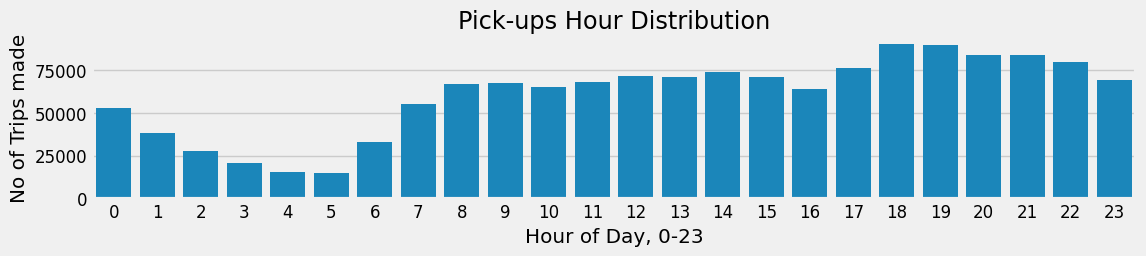

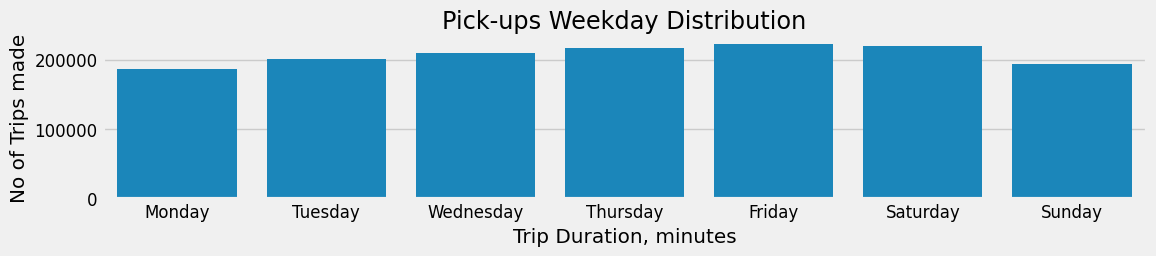

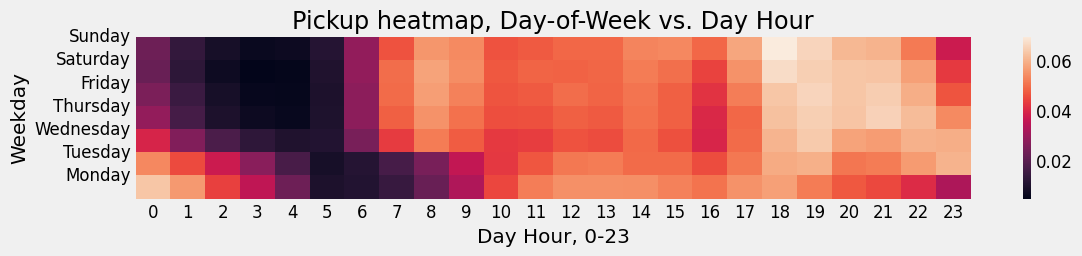

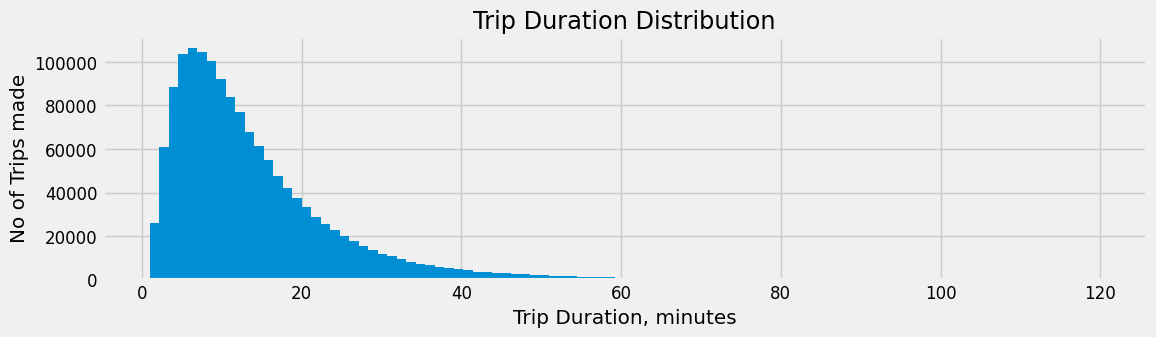

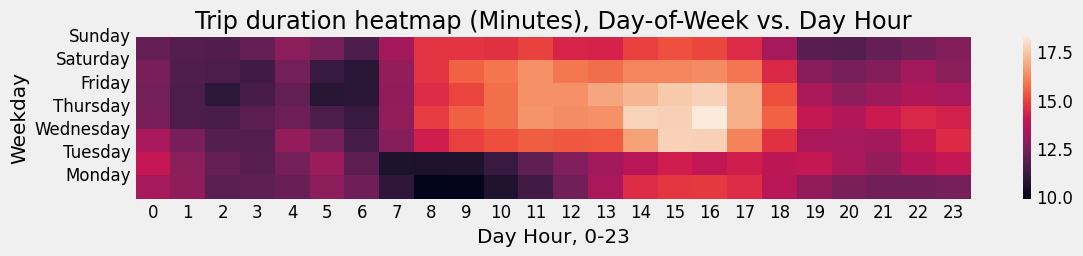

In [ ]:
if __name__ == '__main__':
    # Load train data
    taxiDB = pd.read_csv(filepath_or_buffer='/content/nyc-taxi-trip-duration/train/train.csv', engine='c', infer_datetime_format=True, parse_dates=[2,3])

    # Clean data
    taxiDB = clean(taxiDB)

    # Let's add some additional columns to speed-up calculations dow names for plot mapping
    dow_names = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

    # Visualization for Pick-Up feature
    PickupPlot1(taxiDB)
    PickupPlot2(taxiDB, dow_names)
    PickupPlot3(taxiDB, dow_names)

    # Visualization for Trip Duration feature
    TripDurationPlot1(taxiDB)
    TripDurationPlot2(taxiDB, dow_names)

SOPHISTICATED ANALYSIS



In [ ]:
# Import Packages
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from sklearn import decomposition
from scipy import stats
from sklearn import cluster

In [ ]:
matplotlib.style.use('fivethirtyeight')
matplotlib.rcParams['font.size'] = 12
matplotlib.rcParams['figure.figsize'] = (10,10)

In [147]:
def preprocess(data):
    '''
    Function to pre-process data and return lattitude/longtitude coordinates
    '''

    # remove obvious outliers
    allLat = np.array(list(data['pickup_latitude']) + list(data['dropoff_latitude']))
    allLong = np.array(list(data['pickup_longitude']) + list(data['dropoff_longitude']))

    longLimits = [np.percentile(allLong, 0.3), np.percentile(allLong, 99.7)]
    latLimits  = [np.percentile(allLat , 0.3), np.percentile(allLat , 99.7)]
    durLimits  = [np.percentile(data['trip_duration'], 0.4), np.percentile(data['trip_duration'], 99.7)]

    data = data[(data['pickup_latitude']   >= latLimits[0] ) & (data['pickup_latitude']   <= latLimits[1]) ]
    data = data[(data['dropoff_latitude']  >= latLimits[0] ) & (data['dropoff_latitude']  <= latLimits[1]) ]
    data = data[(data['pickup_longitude']  >= longLimits[0]) & (data['pickup_longitude']  <= longLimits[1])]
    data = data[(data['dropoff_longitude'] >= longLimits[0]) & (data['dropoff_longitude'] <= longLimits[1])]
    data = data[(data['trip_duration']     >= durLimits[0] ) & (data['trip_duration']     <= durLimits[1]) ]
    data = data.reset_index(drop=True)

    allLat = np.array(list(data['pickup_latitude']) + list(data['dropoff_latitude']))
    allLong = np.array(list(data['pickup_longitude']) + list(data['dropoff_longitude']))

    # convert fields to sensible units
    medianLat = np.percentile(allLat,50)
    medianLong = np.percentile(allLong,50)

    latMultiplier = 111.32
    longMultiplier = np.cos(medianLat*(np.pi/180.0)) * 111.32

    data['duration [min]'] = data['trip_duration']/60.0
    data['src lat [km]']   = latMultiplier  * (data['pickup_latitude']   - medianLat)
    data['src long [km]']  = longMultiplier * (data['pickup_longitude']  - medianLong)
    data['dst lat [km]']   = latMultiplier  * (data['dropoff_latitude']  - medianLat)
    data['dst long [km]']  = longMultiplier * (data['dropoff_longitude'] - medianLong)

    allLat  = np.array(list(data['src lat [km]'])  + list(data['dst lat [km]']))
    allLong = np.array(list(data['src long [km]']) + list(data['dst long [km]']))

    return allLat, allLong,data


In [148]:
def plotHist(allLat, allLong, data):
    '''
    Function to plot histograms of trip duration, latitude and longitude
    '''

    fig, axArray = plt.subplots(nrows=1, ncols=3, figsize=(13,4))

    axArray[0].hist(data['duration [min]'], 80)
    axArray[0].set_xlabel('trip duration [min]')
    axArray[0].set_ylabel('counts')
    axArray[1].hist(allLat, 80)
    axArray[1].set_xlabel('latitude [km]')
    axArray[2].hist(allLong, 80)
    axArray[2].set_xlabel('longitude [km]')

    plt.savefig('Figures/trip-duration-lat-long.png')

In [149]:
def plotDurationDistance(data):
    '''
    Function to plot the trip duration vs the aerial distance between pickup and dropoff
    '''

    data['log duration'] = np.log1p(data['duration [min]'])
    data['euclidian distance'] = np.sqrt((data['src lat [km]'] - data['dst lat [km]'] ) ** 2 +
                                           (data['src long [km]'] - data['dst long [km]']) ** 2)

    fig, axArray = plt.subplots(nrows=1, ncols=2, figsize=(13,6))

    axArray[0].scatter(data['euclidian distance'], data['duration [min]'], c='r', s=5, alpha=0.01)
    axArray[0].set_xlabel('Aerial Euclidian Distance [km]')
    axArray[0].set_ylabel('Duration [min]')
    axArray[0].set_xlim(data['euclidian distance'].min(),data['euclidian distance'].max())
    axArray[0].set_ylim(data['duration [min]'].min(),data['duration [min]'].max())
    axArray[0].set_title('trip Duration vs Aerial trip Distance')

    axArray[1].scatter(data['euclidian distance'], data['log duration'], c='r', s=5, alpha=0.01)
    axArray[1].set_xlabel('Aerial Euclidian Distance [km]')
    axArray[1].set_ylabel('log(1+Duration) [log(min)]')
    axArray[1].set_xlim(data['euclidian distance'].min(),data['euclidian distance'].max())
    axArray[1].set_ylim(data['log duration'].min(),data['log duration'].max())
    axArray[1].set_title('log of trip Duration vs Aerial trip Distance')

    plt.savefig('Figures/trip-duration-aerial-distance-pickup-dropoff.png')

In [150]:
def plotTripCluster(data, numClusters):
    '''
    Function to cluster all 1.4 million trips to 80 stereotypical template trips and then look at the distribution of this "bag of trips" and how it changes over time.
    '''

    tripAttributes = np.array(data.loc[:,['src lat [km]','src long [km]','dst lat [km]','dst long [km]','duration [min]']])
    meanTripAttr = tripAttributes.mean(axis=0)
    stdTripAttr  = tripAttributes.std(axis=0)
    tripAttributes = stats.zscore(tripAttributes, axis=0)

    TripKmeansModel = cluster.MiniBatchKMeans(n_clusters=numClusters, batch_size=120000, n_init=100, random_state=1)
    clusterInds = TripKmeansModel.fit_predict(tripAttributes)

    clusterTotalCounts, _ = np.histogram(clusterInds, bins=numClusters)
    sortedClusterInds = np.flipud(np.argsort(clusterTotalCounts))

    plt.figure(figsize=(12,4))
    plt.title('Cluster Histogram of all trip')
    plt.bar(range(1,numClusters+1),clusterTotalCounts[sortedClusterInds])
    plt.ylabel('Frequency [counts]')
    plt.xlabel('Cluster index (sorted by cluster frequency)')
    plt.xlim(0,numClusters + 1)

    plt.savefig('Figures/cluster-histogram-trip.png')

    return meanTripAttr, stdTripAttr

In [151]:
def plotSpatialDensity(allLat, allLong, latRange, longRange, imageSize):
    '''
    Function to plot spatial density plot of the pickup and dropoff locations
    '''

    allLatInds  = imageSize[0] - (imageSize[0] * (allLat  - latRange[0])  / (latRange[1]  - latRange[0]) ).astype(int)
    allLongInds = (imageSize[1] * (allLong - longRange[0]) / (longRange[1] - longRange[0])).astype(int)

    locationDensityImage = np.zeros(imageSize)
    for latInd, longInd in zip(allLatInds, allLongInds):
        locationDensityImage[latInd, longInd] += 1

    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12,12))
    ax.imshow(np.log(locationDensityImage + 1), cmap='hot')
    ax.set_axis_off()

    plt.savefig('Figures/spatial-density-pickup-dropoff.png')

    return locationDensityImage

In [152]:
def plotTripCluster(data, numClusters):
    '''
    Function to cluster all 1.4 million trips to 80 stereotypical template trips and then look at the distribution of this "bag of trips" and how it changes over time.
    '''

    tripAttributes = np.array(data.loc[:,['src lat [km]','src long [km]','dst lat [km]','dst long [km]','duration [min]']])
    meanTripAttr = tripAttributes.mean(axis=0)
    stdTripAttr  = tripAttributes.std(axis=0)
    tripAttributes = stats.zscore(tripAttributes, axis=0)

    TripKmeansModel = cluster.MiniBatchKMeans(n_clusters=numClusters, batch_size=120000, n_init=100, random_state=1)
    clusterInds = TripKmeansModel.fit_predict(tripAttributes)

    clusterTotalCounts, _ = np.histogram(clusterInds, bins=numClusters)
    sortedClusterInds = np.flipud(np.argsort(clusterTotalCounts))

    plt.figure(figsize=(12,4))
    plt.title('Cluster Histogram of all trip')
    plt.bar(range(1,numClusters+1),clusterTotalCounts[sortedClusterInds])
    plt.ylabel('Frequency [counts]')
    plt.xlabel('Cluster index (sorted by cluster frequency)')
    plt.xlim(0,numClusters + 1)

    plt.savefig('Figures/cluster-histogram-trip.png')

    return meanTripAttr, stdTripAttr

In [153]:
def ConvertToImageCoords(latCoord, longCoord, latRange, longRange, imageSize):
    '''
    Function to image coordinates
    '''

    latInds = imageSize[0] - (imageSize[0] * (latCoord  - latRange[0])  / (latRange[1]  - latRange[0]) ).astype(int)
    longInds = (imageSize[1] * (longCoord - longRange[0]) / (longRange[1] - longRange[0])).astype(int)
    return latInds, longInds

In [158]:
def plotTypicalTrips(meanTripAttr, stdTripAttr, numClusters, latRange, longRange, imageSize, locationDensityImage):
    '''
    Function to show the template trips on the map
    '''

    templateTrips = TripKmeansModel.cluster_centers_ * np.tile(stdTripAttr, (numClusters, 1)) + np.tile(meanTripAttr,(numClusters, 1))

    srcCoords = templateTrips[:, :2]
    dstCoords = templateTrips[:, 2:4]

    srcImCoords = ConvertToImageCoords(srcCoords[:, 0],srcCoords[:, 1], latRange, longRange, imageSize)
    dstImCoords = ConvertToImageCoords(dstCoords[:, 0],dstCoords[:, 1], latRange, longRange, imageSize)

    plt.figure(figsize=(12,12))
    plt.imshow(np.log(locationDensityImage + 1), cmap='hot')
    plt.grid('off')
    plt.scatter(srcImCoords[1], srcImCoords[0], c='m', s=200, alpha=0.8)
    plt.scatter(dstImCoords[1], dstImCoords[0], c='g', s=200, alpha=0.8)

    for i in range(len(srcImCoords[0])):
        plt.arrow(srcImCoords[1][i], srcImCoords[0][i],
                dstImCoords[1][i]-srcImCoords[1][i],
                dstImCoords[0][i]-srcImCoords[0][i],
                edgecolor='c', facecolor='c',
                width=0.8,
                alpha=0.4,
                head_width=10.0,
                head_length=10.0,
                length_includes_head=True)

    plt.savefig('Figures/typical-trips.png')

NameError: name 'TripKmeansModel' is not defined

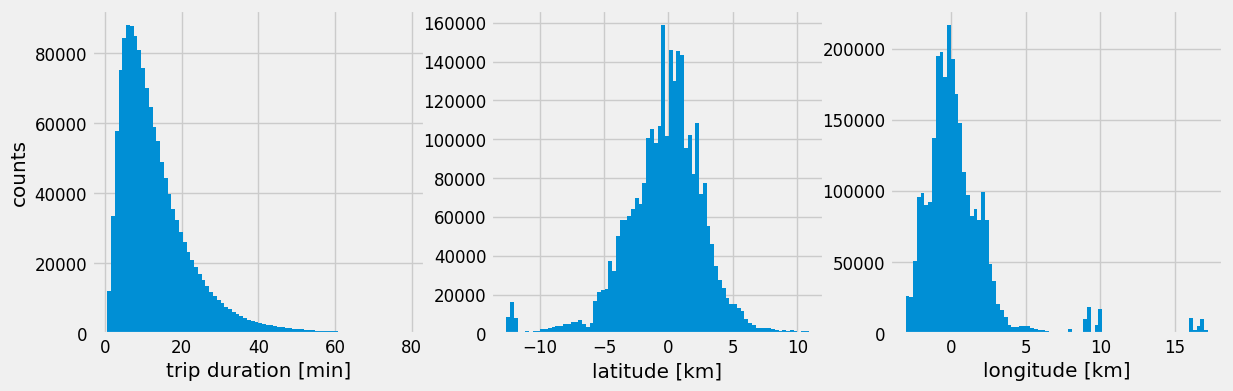

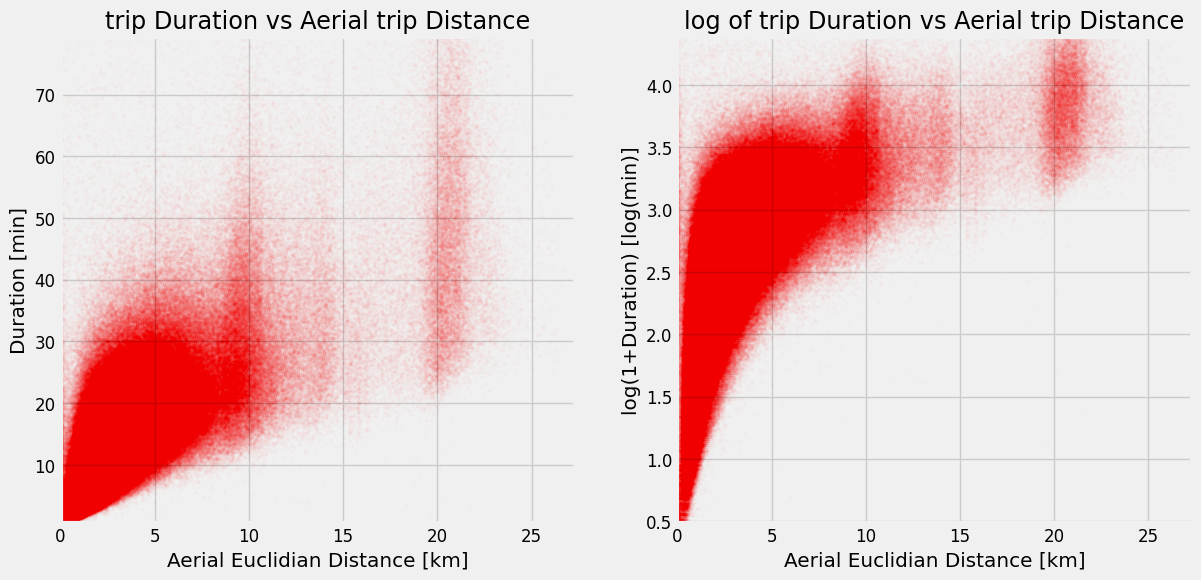

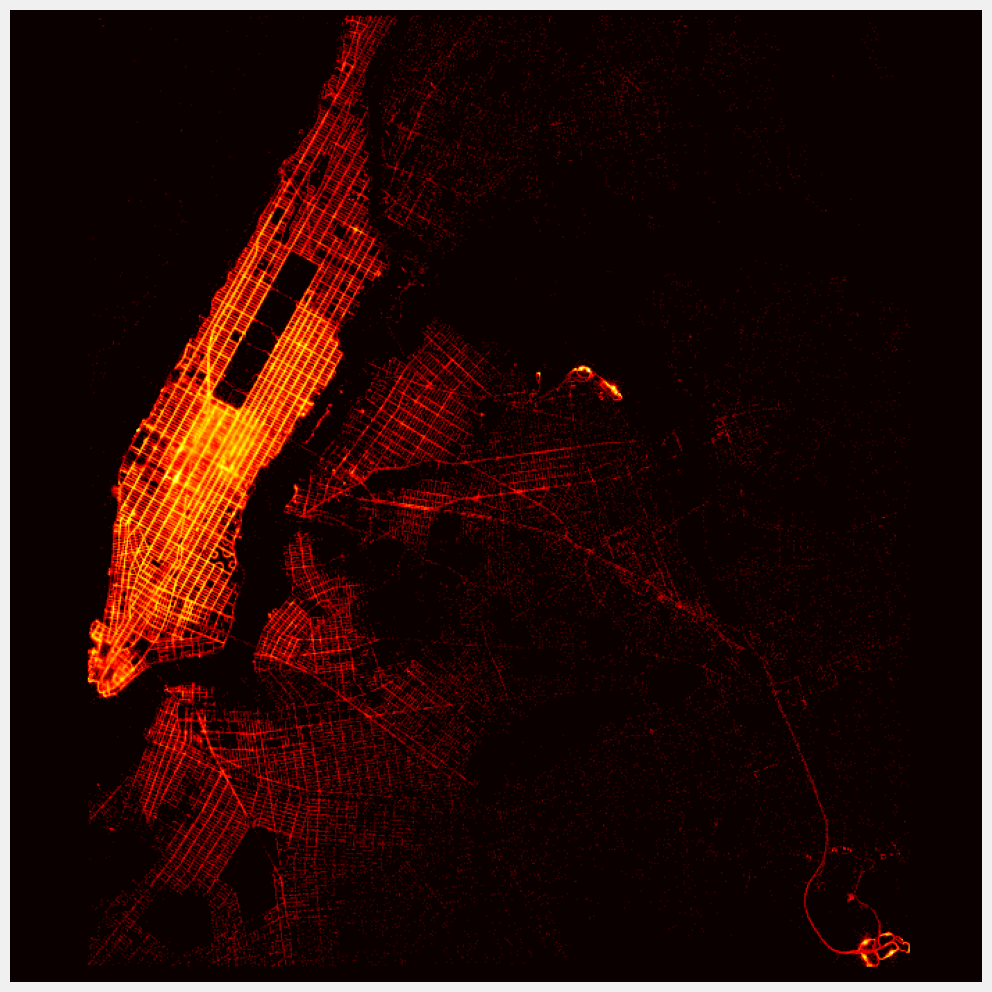

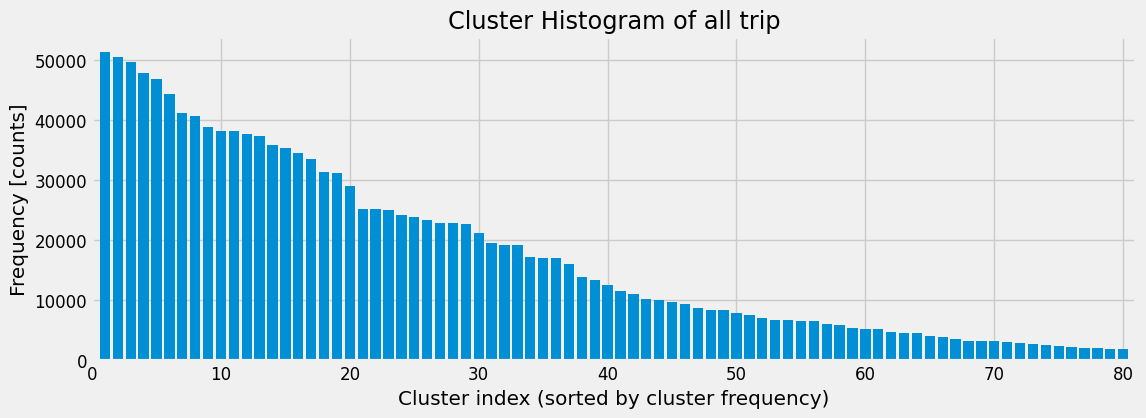

In [160]:
if __name__ == '__main__':
    # Read train file
    dataDir = '/content/nyc-taxi-trip-duration/train/'
    taxiDB = pd.read_csv(dataDir + 'train.csv')

    # Pre-process data
    allLat, allLong, taxiDB = preprocess(taxiDB)

    # Plot the resulting histograms of trip duration, latitude and longitude
    plotHist(allLat, allLong, taxiDB)

    # Plot the trip Duration vs the Aerial Distance between pickup and dropoff
    plotDurationDistance(taxiDB)

    # Show the log density of pickup and dropoff locations
    imageSize = (700, 700)
    longRange = [-5, 19]
    latRange = [-13, 11]
    # Plot spatial density plot of the pickup and dropoff locations
    locationDensityImage = plotSpatialDensity(allLat, allLong, latRange, longRange, imageSize)

    # Create useful fields to be used
    pickupTime = pd.to_datetime(taxiDB['pickup_datetime'])

    taxiDB['src hourOfDay'] = (pickupTime.dt.hour * 60.0 + pickupTime.dt.minute) / 60.0
    taxiDB['dst hourOfDay'] = taxiDB['src hourOfDay'] + taxiDB['duration [min]'] / 60.0

    taxiDB['dayOfWeek'] = pickupTime.dt.weekday
    taxiDB['hourOfWeek'] = taxiDB['dayOfWeek'] * 24.0 + taxiDB['src hourOfDay']

    taxiDB['monthOfYear'] = pickupTime.dt.month
    taxiDB['dayOfYear'] = pickupTime.dt.dayofyear
    taxiDB['weekOfYear'] = pickupTime.dt.isocalendar().week
    taxiDB['hourOfYear'] = taxiDB['dayOfYear'] * 24.0 + taxiDB['src hourOfDay']

    # Plot trip clusters and their distribution
    numClusters = 80
    meanTripAttr, stdTripAttr = plotTripCluster(taxiDB, numClusters)

    # Show the typical trips on the map
    plotTypicalTrips(meanTripAttr, stdTripAttr, numClusters, latRange, longRange, imageSize, locationDensityImage)

In [161]:
def plotTripCluster(data, numClusters):
    '''
    Function to cluster all 1.4 million trips to 80 stereotypical template trips and then look at the distribution of this "bag of trips" and how it changes over time.
    '''

    tripAttributes = np.array(data.loc[:,['src lat [km]','src long [km]','dst lat [km]','dst long [km]','duration [min]']])
    meanTripAttr = tripAttributes.mean(axis=0)
    stdTripAttr  = tripAttributes.std(axis=0)
    tripAttributes = stats.zscore(tripAttributes, axis=0)

    TripKmeansModel = cluster.MiniBatchKMeans(n_clusters=numClusters, batch_size=120000, n_init=100, random_state=1)
    clusterInds = TripKmeansModel.fit_predict(tripAttributes)

    clusterTotalCounts, _ = np.histogram(clusterInds, bins=numClusters)
    sortedClusterInds = np.flipud(np.argsort(clusterTotalCounts))

    plt.figure(figsize=(12,4))
    plt.title('Cluster Histogram of all trip')
    plt.bar(range(1,numClusters+1),clusterTotalCounts[sortedClusterInds])
    plt.ylabel('Frequency [counts]')
    plt.xlabel('Cluster index (sorted by cluster frequency)')
    plt.xlim(0,numClusters + 1)

    plt.savefig('Figures/cluster-histogram-trip.png')

    return meanTripAttr, stdTripAttr, TripKmeansModel

In [162]:
def plotTypicalTrips(meanTripAttr, stdTripAttr, numClusters, latRange, longRange, imageSize, locationDensityImage, TripKmeansModel):
    '''
    Function to show the template trips on the map
    '''

    templateTrips = TripKmeansModel.cluster_centers_ * np.tile(stdTripAttr, (numClusters, 1)) + np.tile(meanTripAttr,(numClusters, 1))

    srcCoords = templateTrips[:, :2]
    dstCoords = templateTrips[:, 2:4]

    srcImCoords = ConvertToImageCoords(srcCoords[:, 0],srcCoords[:, 1], latRange, longRange, imageSize)
    dstImCoords = ConvertToImageCoords(dstCoords[:, 0],dstCoords[:, 1], latRange, longRange, imageSize)

    plt.figure(figsize=(12,12))
    plt.imshow(np.log(locationDensityImage + 1), cmap='hot')
    plt.grid('off')
    plt.scatter(srcImCoords[1], srcImCoords[0], c='m', s=200, alpha=0.8)
    plt.scatter(dstImCoords[1], dstImCoords[0], c='g', s=200, alpha=0.8)

    for i in range(len(srcImCoords[0])):
        plt.arrow(srcImCoords[1][i], srcImCoords[0][i],
                dstImCoords[1][i]-srcImCoords[1][i],
                dstImCoords[0][i]-srcImCoords[0][i],
                edgecolor='c', facecolor='c',
                width=0.8,
                alpha=0.4,
                head_width=10.0,
                head_length=10.0,
                length_includes_head=True)

    plt.savefig('Figures/typical-trips.png')

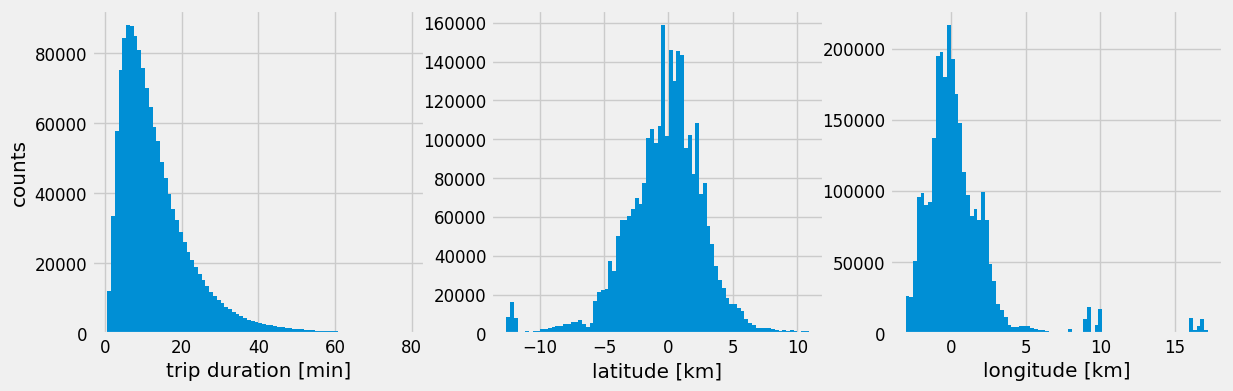

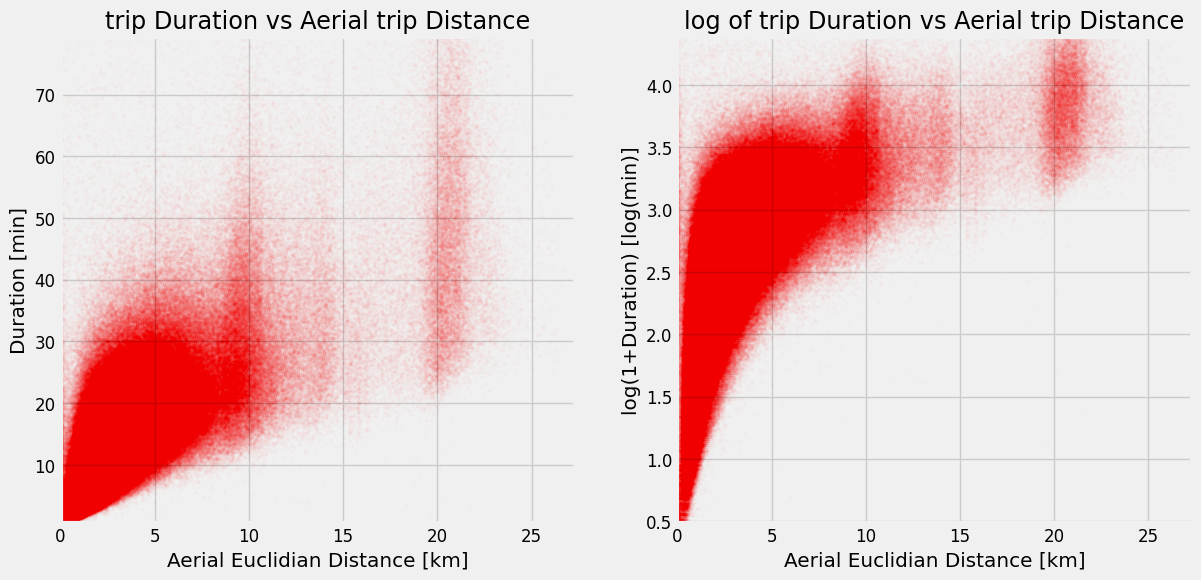

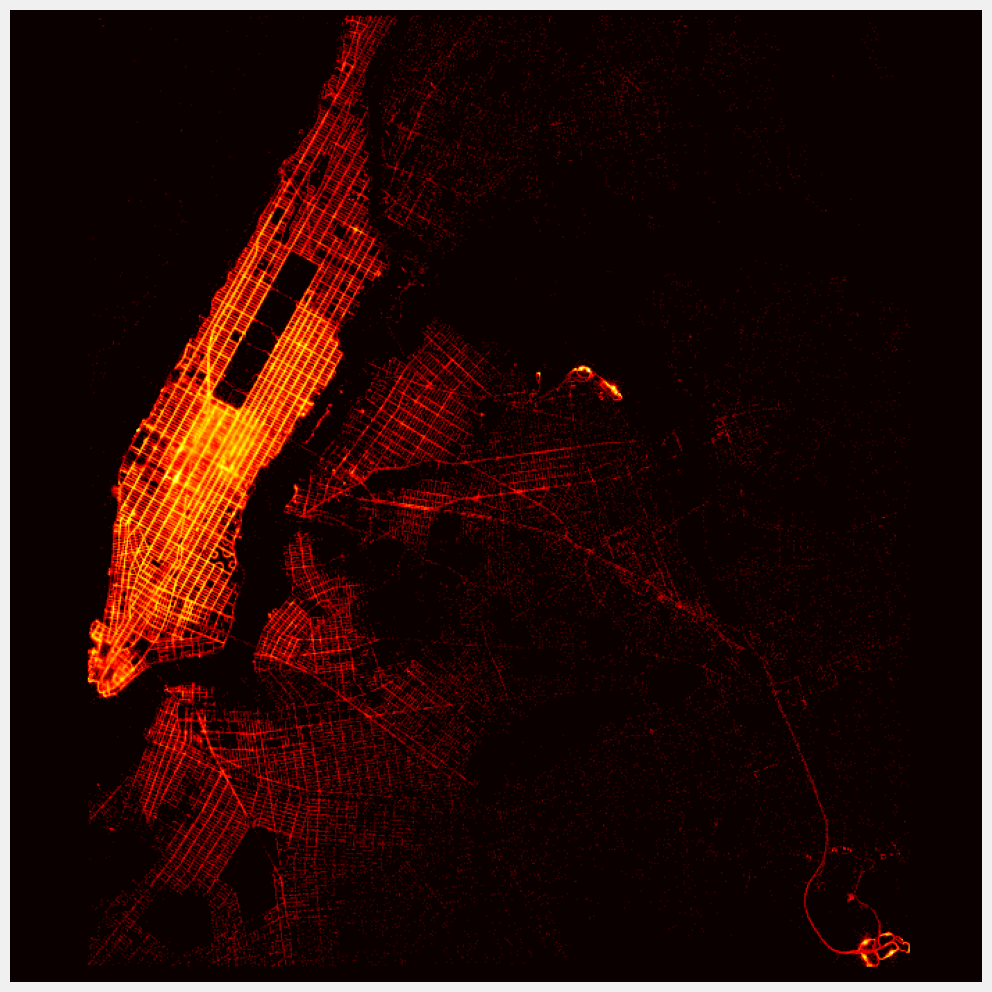

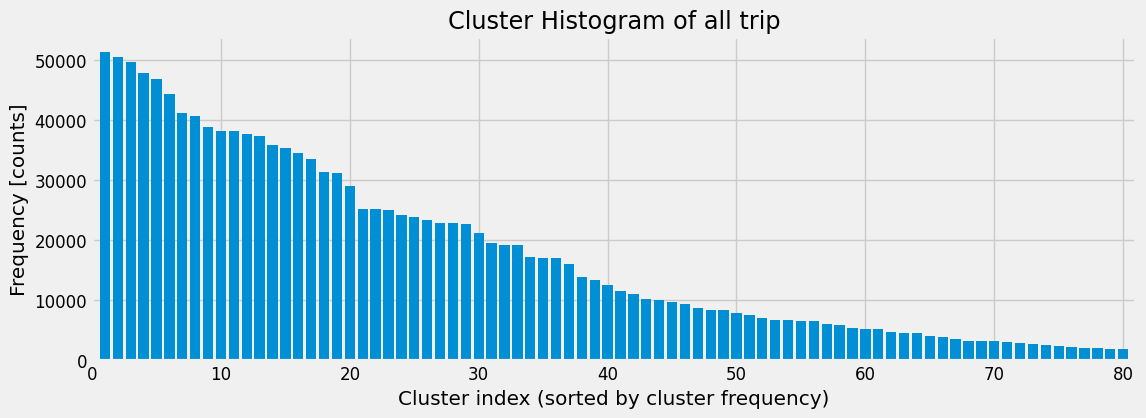

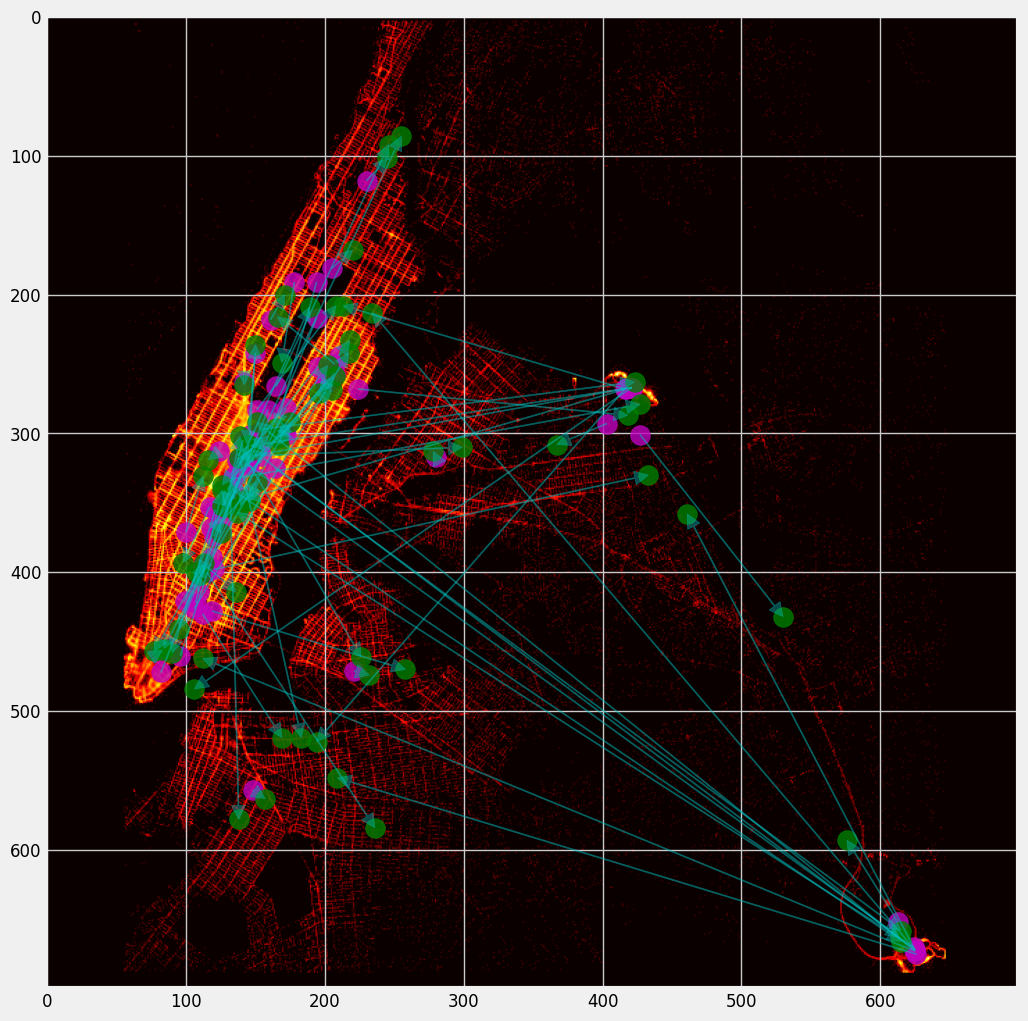

In [164]:
if __name__ == '__main__':
    # Read train file
    dataDir = '/content/nyc-taxi-trip-duration/train/'
    taxiDB = pd.read_csv(dataDir + 'train.csv')

    # Pre-process data
    allLat, allLong, taxiDB = preprocess(taxiDB)

    # Plot the resulting histograms of trip duration, latitude and longitude
    plotHist(allLat, allLong, taxiDB)

    # Plot the trip Duration vs the Aerial Distance between pickup and dropoff
    plotDurationDistance(taxiDB)

    # Show the log density of pickup and dropoff locations
    imageSize = (700, 700)
    longRange = [-5, 19]
    latRange = [-13, 11]
    # Plot spatial density plot of the pickup and dropoff locations
    locationDensityImage = plotSpatialDensity(allLat, allLong, latRange, longRange, imageSize)

    # Create useful fields to be used
    pickupTime = pd.to_datetime(taxiDB['pickup_datetime'])

    taxiDB['src hourOfDay'] = (pickupTime.dt.hour * 60.0 + pickupTime.dt.minute) / 60.0
    taxiDB['dst hourOfDay'] = taxiDB['src hourOfDay'] + taxiDB['duration [min]'] / 60.0

    taxiDB['dayOfWeek'] = pickupTime.dt.weekday
    taxiDB['hourOfWeek'] = taxiDB['dayOfWeek'] * 24.0 + taxiDB['src hourOfDay']

    taxiDB['monthOfYear'] = pickupTime.dt.month
    taxiDB['dayOfYear'] = pickupTime.dt.dayofyear
    taxiDB['weekOfYear'] = pickupTime.dt.isocalendar().week
    taxiDB['hourOfYear'] = taxiDB['dayOfYear'] * 24.0 + taxiDB['src hourOfDay']

    # Plot trip clusters and their distribution
    numClusters = 80
    meanTripAttr, stdTripAttr, TripKmeansModel = plotTripCluster(taxiDB, numClusters)

    # Show the typical trips on the map
    plotTypicalTrips(meanTripAttr, stdTripAttr, numClusters, latRange, longRange, imageSize, locationDensityImage, TripKmeansModel)